In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 13})
%matplotlib inline

from platform import python_version

print(python_version())## Full set of equations

We take the observable state $s$ to live in a discretized field of $N$ total states that are sampled uniformely at each iteration and $z$ to be a binary variable that is zero in one half of the state distribution and one in the other half.

* $d(s,z) = KL[\pi(a|s)||\pi(a|z)]$
* $p(z) = \sum_s p(s)\rho(z|s)$
    * $ = \tau \sum_s \rho(z|s)$
* $Z(s,\beta) = \sum_z p(z) e^{-\beta d(s,z)}$
* $p(s) = \tau$, we define the observed state distribution as an uniform distribution
* $\pi(a|s)$ - we define this distribution as the optimal solution to the problem
* $\rho(z|s) = \frac{p(z)}{Z(s,\beta)}e^{-\beta d(z,s)}$
* $\rho(s|z) \propto \rho(z|s) p(s)$
* $\pi(a|z) = \sum_a \pi(a|s)\rho(s|z)$  

## Algorithm steps:


### Goals:

1. Prove that this set of equations converge to what's expected in $\pi(a|z)$

### Tasks:
1. Rederive the set of iterative equations 

In [4]:
# auxiliary functions

def KL_div(pi_s, pi_z):
    # pi_s[a,s], pi_z[a,z]
    
    kldiv = 0
    
    n_states = pi_s.shape[1]
    n_latent = pi_z.shape[1]
    n_actions = pi_s.shape[0]
    
    #print('n_s: ', n_states, 'n_z: ', n_latent, 'n_actions: ', n_actions)
    
    for s in range(n_states):
        for z in range(n_latent):
            for a in range(n_actions):
                kldiv += pi_z[a, z] * np.log(pi_z[a,z]/pi_s[a,s])
    return kldiv

def get_d_sz(pi_s,pi_z):
    # pi_s[a,s], pi_z[a,z]
    
    n_states = pi_s.shape[1]
    n_latent = pi_z.shape[1]
    n_actions = pi_s.shape[0]
    
    d_sz = np.zeros((n_states, n_latent))
    for s in range(n_states):
        for z in range(n_latent):
            for a in range(n_actions):
                d_sz[s,z] += pi_z[a, z] * np.log(pi_z[a,z]/pi_s[a,s])
    return d_sz

def get_d_sz2(pi_s,pi_z):
    # pi_s[a,s], pi_z[a,z]
    
    n_states = pi_s.shape[1]
    n_latent = pi_z.shape[1]
    n_actions = pi_s.shape[0]
    
    d_sz = np.zeros((n_states, n_latent))
    for s in range(n_states):
        for z in range(n_latent):
            for a in range(n_actions):
                d_sz[s,z] += pi_s[a, s] * np.log(pi_s[a,s]/pi_z[a,z])
    return d_sz

def normalize_dist(dist):
    return dist/np.sum(dist)

# running IB multiple times, average over $\pi_z$

In [5]:
def check_pi_solution(pi_z_t):
    # takes a vector of attempts at solution from IB and checks if correct
    sol_v = []
    c_count = 0
    i_count = 0
    for i,e in enumerate(pi_z_t):
        if e[0,0] > e[0,1] and e[1,1] > e[1,0]:
            sol_v.append([i, 'C'])
            c_count += 1
        else:
            sol_v.append([i, 'I'])
            i_count += 1
    print('corr ratio:', c_count/(c_count+i_count))
    return sol_v

In [6]:
def run_IB(n_iters, pi_z_init, n_steps, pi_s):
    
    # global variables
    n_states = 4 # definition of s
    n_latent = 2 # definition of z
    n_actions = 2 # definition of a
    beta = 2

    # iterative functions
    p_s = 1/n_states - 0.001 # uniform probability for each state - added help of normalization
    pi_z_h = []
    
    for n in range(n_iters):
        
        p_z = np.array([0.5,0.5])
        p_z = normalize_dist(p_z)
        pi_z = pi_z_init
        d_sz = np.zeros((n_states, n_latent))
        Z_sb = np.zeros((n_states))
        rho_zs = np.zeros((n_latent, n_states))

        for t in range(n_steps):

            d_sz = get_d_sz(pi_s, pi_z)

            # update Z_sb
            Z_sb = np.zeros((n_states))
            for s in range(n_states):
                for z in range(n_latent):
                    Z_sb[s] += p_z[z] * np.exp(-beta * d_sz[s,z])

            # update rho_zs
            for s in range(n_states):
                for z in range(n_latent):
                    rho_zs[z,s] = (p_z[z]/Z_sb[s]) * np.exp(-beta * d_sz[s,z])

            # update p_z
            p_z = np.zeros(n_latent)
            for z in range(n_latent):
                for s in range(n_states):
                    p_z[z] += rho_zs[z,s] * p_s

            # update pi_z
            pi_z = np.zeros((n_actions, n_latent))
            for a in range(n_actions):
                for z in range(n_latent):
                    for s in range(n_states):
                        pi_z[a,z] +=  p_s * pi_s[a,s] * rho_zs[z,s] / p_z[z]
        
            pi_z_h.append(pi_z)

        pi_z_h = np.asarray(pi_z_h)
        
        return np.asarray(pi_z_h), rho_zs

In [7]:
def plot_pi_z_sols(pi_z_t):
    
    n_iters = pi_z_t.shape[0]
    
    fig = plt.figure(figsize = [7,7])
    gs = GridSpec(10, 10)
    ax = []
    for i in range(n_iters):
        ax.append([])
        ax[i] = fig.add_subplot(gs[i])

    c_count = 0
    i_count = 0
    sv = check_pi_solution(pi_z_t)
    for i in range(n_iters):
        if sv[i][1] == 'C':
            ax[i].imshow(pi_z_t[i,:,:], 'Blues')
            c_count += 1
        else:
            ax[i].imshow(pi_z_t[i,:,:], 'Reds')
            i_count += 1
        ax[i].tick_params(labelbottom=False, labelleft=False, bottom = False, left = False)
    #print('correct ratio: ', c_count/(c_count+i_count))
    plt.show()

# starting multiple sims with different initial conditions

## checking some random trajectories of $\pi_z$

In [8]:
# global variables
n_states = 4 # definition of s
n_latent = 2 # definition of z
n_actions = 2 # definition of a

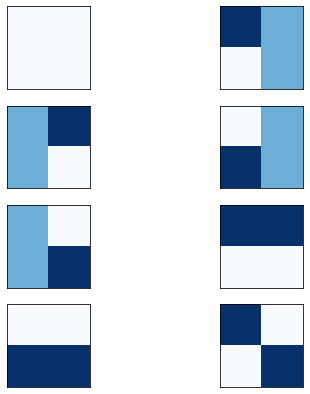

In [9]:
# create list of initial conditions
# simulate multiple runs
pi_z_inits_ds = []

#pi_z = np.zeros((n_actions, n_latent))
#pi_z[0,0] = 0.023
#pi_z[0,1] = 0.01
#pi_z[1,0] = 0.01
#pi_z[1,1] = 0.02
#pi_z = pi_z / pi_z.sum(axis=0)
#pi_z_inits_ds.append(pi_z)

pi_z = np.zeros((n_actions, n_latent))
pi_z[0,0] = 0.01
pi_z[0,1] = 0.01
pi_z[1,0] = 0.01
pi_z[1,1] = 0.01
pi_z = pi_z / pi_z.sum(axis=0)
pi_z_inits_ds.append(pi_z)

pi_z = np.zeros((n_actions, n_latent))
pi_z[0,0] = 0.02
pi_z[0,1] = 0.01
pi_z[1,0] = 0.01
pi_z[1,1] = 0.01
pi_z = pi_z / pi_z.sum(axis=0)
pi_z_inits_ds.append(pi_z)

pi_z = np.zeros((n_actions, n_latent))
pi_z[0,0] = 0.01
pi_z[0,1] = 0.02
pi_z[1,0] = 0.01
pi_z[1,1] = 0.01
pi_z = pi_z / pi_z.sum(axis=0)
pi_z_inits_ds.append(pi_z)

pi_z = np.zeros((n_actions, n_latent))
pi_z[0,0] = 0.01
pi_z[0,1] = 0.01
pi_z[1,0] = 0.02
pi_z[1,1] = 0.01
pi_z = pi_z / pi_z.sum(axis=0)
pi_z_inits_ds.append(pi_z)

pi_z = np.zeros((n_actions, n_latent))
pi_z[0,0] = 0.01
pi_z[0,1] = 0.01
pi_z[1,0] = 0.01
pi_z[1,1] = 0.02
pi_z = pi_z / pi_z.sum(axis=0)
pi_z_inits_ds.append(pi_z)

pi_z = np.zeros((n_actions, n_latent))
pi_z[0,0] = 0.02
pi_z[0,1] = 0.02
pi_z[1,0] = 0.01
pi_z[1,1] = 0.01
pi_z = pi_z / pi_z.sum(axis=0)
pi_z_inits_ds.append(pi_z)

pi_z = np.zeros((n_actions, n_latent))
pi_z[0,0] = 0.01
pi_z[0,1] = 0.01
pi_z[1,0] = 0.02
pi_z[1,1] = 0.02
pi_z = pi_z / pi_z.sum(axis=0)
pi_z_inits_ds.append(pi_z)

pi_z = np.zeros((n_actions, n_latent))
pi_z[0,0] = 0.02
pi_z[0,1] = 0.01
pi_z[1,0] = 0.01
pi_z[1,1] = 0.02
pi_z = pi_z / pi_z.sum(axis=0)
pi_z_inits_ds.append(pi_z)

fig = plt.figure(figsize = [7,7])
gs = GridSpec(4, 2)
ax = []
for i,e in enumerate(pi_z_inits_ds):
    ax.append([])
    ax[i] = fig.add_subplot(gs[i])
    ax[i].imshow(e, 'Blues')
    ax[i].tick_params(labelbottom=False, labelleft=False, bottom = False, left = False)
plt.show()

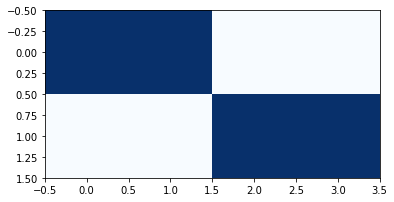

In [10]:
# normalizing policies over actions 
pi_s = 0.001 * np.ones((n_actions, n_states))
pi_s[0,0:int(n_states/2)] = 1
pi_s[1,int(n_states/2):n_states] = 1
pi_s = pi_s / pi_s.sum(axis=0)

plt.imshow(pi_s, 'Blues')

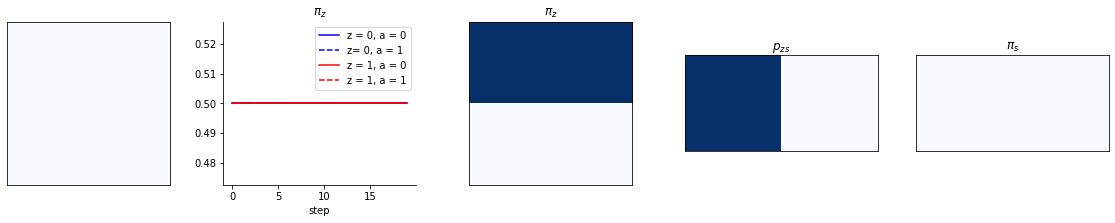

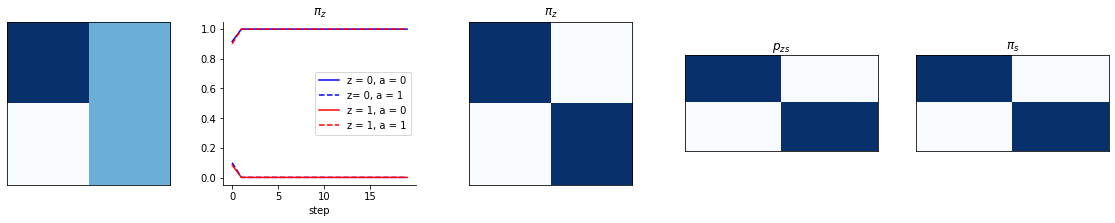

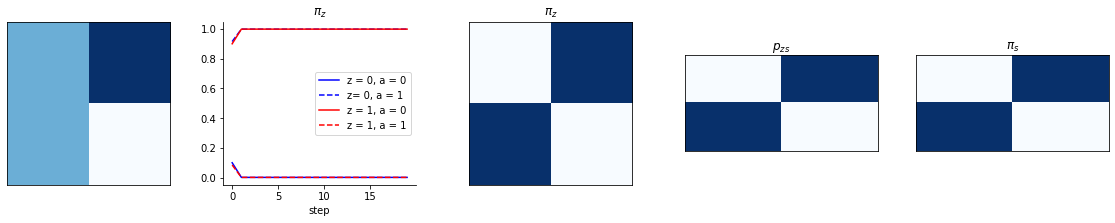

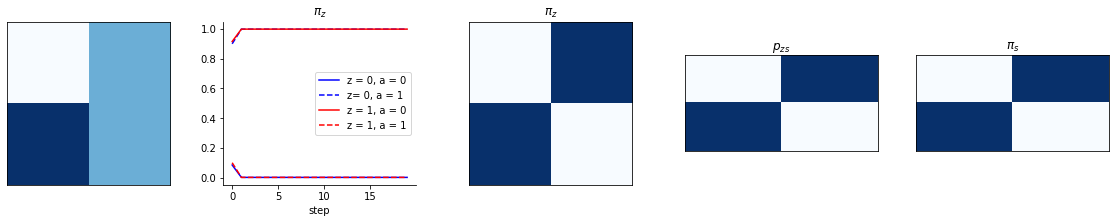

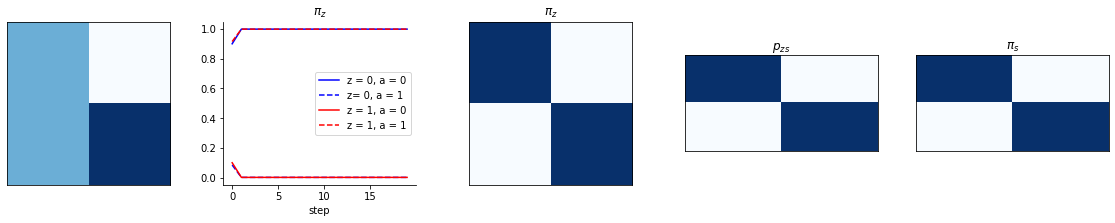

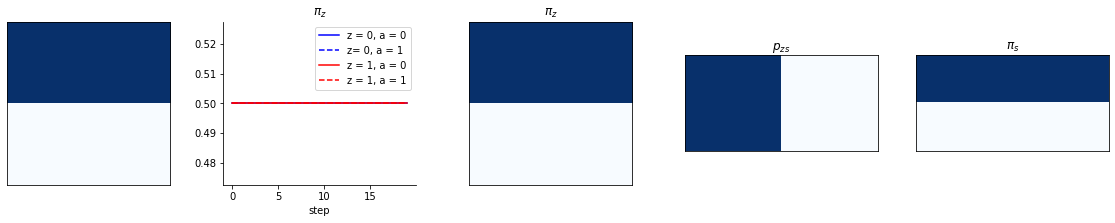

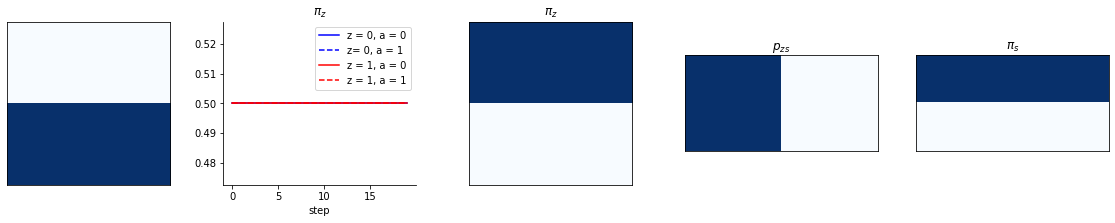

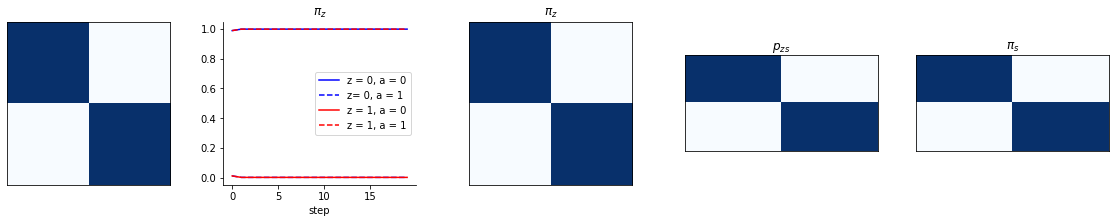

In [11]:
pi_z_sol = []
rho_zs_cond = np.zeros((len(pi_z_inits_ds), n_latent, n_states))

for i,e in enumerate(pi_z_inits_ds):
    
    pi_z_h, rho_zs = run_IB(20, e, 20, pi_s)
    pi_z_sol.append(pi_z_h[-1])
    rho_zs_cond[i] = rho_zs
    
    fig = plt.figure(figsize = [20,3])
    gs = GridSpec(1,5)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])
    ax5 = fig.add_subplot(gs[4])
    
    ax1.imshow(e, 'Blues')
    ax1.tick_params(labelbottom=False, labelleft=False, bottom = False, left = False)
    
    ax2.plot(pi_z_h[:,0,0], 'b', label = 'z = 0, a = 0')
    ax2.plot(pi_z_h[:,0,1], 'b--', label = 'z= 0, a = 1')
    ax2.plot(pi_z_h[:,1,0], 'r', label = 'z = 1, a = 0')
    ax2.plot(pi_z_h[:,1,1], 'r--',label = 'z = 1, a = 1')
    ax2.set_xlabel('step')
    ax2.set_title('$\pi_z$')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.legend()
    
    ax3.set_title('$\pi_z$')
    ax3.imshow(pi_z_h[-1], 'Blues')
    ax3.tick_params(labelbottom=False, labelleft=False, bottom = False, left = False)
    
    ax4.set_title('$p_{zs}$')
    ax4.imshow(rho_zs, 'Blues')
    ax4.tick_params(labelbottom=False, labelleft=False, bottom = False, left = False)
    
    pi_s_calc = np.zeros((n_actions, n_states))
    for a in range(n_actions):
        for s in range(n_states):
            for z in range(n_latent):
                pi_s_calc[a,s] += rho_zs_cond[1,z,s].T * pi_z_h[-1,a,z]
    
    ax5.set_title('$\pi_s$')
    ax5.imshow(pi_s_calc, 'Blues')
    ax5.tick_params(labelbottom=False, labelleft=False, bottom = False, left = False)
    
    #print(check_pi_solution(pi_z_t))
    plt.show()

pi_z_sol = np.asarray(pi_z_sol)

## testing KL minima
* how does the KL loss change with different solutions?
* what is the degeneracy of the solutions of $\pi_s = \sum_z \rho_{zs}\pi_z$

In [12]:
# different support distributions

In [13]:
pi_z_inits_ds

[array([[0.5, 0.5],
        [0.5, 0.5]]),
 array([[0.66666667, 0.5       ],
        [0.33333333, 0.5       ]]),
 array([[0.5       , 0.66666667],
        [0.5       , 0.33333333]]),
 array([[0.33333333, 0.5       ],
        [0.66666667, 0.5       ]]),
 array([[0.5       , 0.33333333],
        [0.5       , 0.66666667]]),
 array([[0.66666667, 0.66666667],
        [0.33333333, 0.33333333]]),
 array([[0.33333333, 0.33333333],
        [0.66666667, 0.66666667]]),
 array([[0.66666667, 0.33333333],
        [0.33333333, 0.66666667]])]

In [14]:
pi_z_sol[4]

array([[0.99899997, 0.00100003],
       [0.00100003, 0.99899997]])

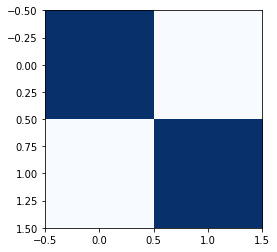

In [15]:
plt.imshow(pi_z_sol[4], 'Blues')

In [16]:
get_d_sz(pi_z_inits_ds[-1], pi_z_sol[2])

array([[1.09001168, 0.39825083],
       [0.39825083, 1.09001168]])

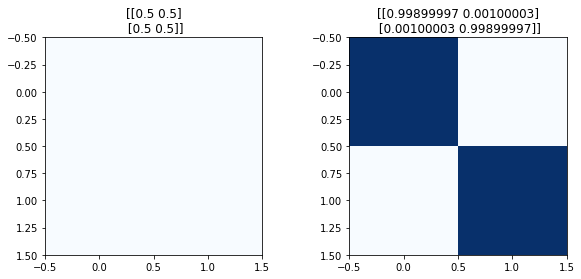

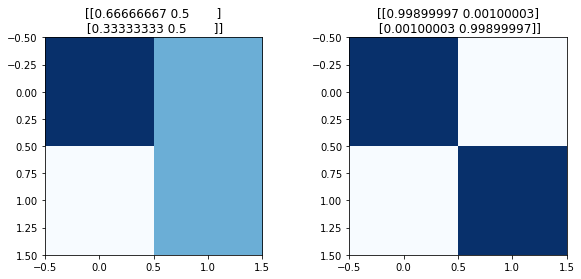

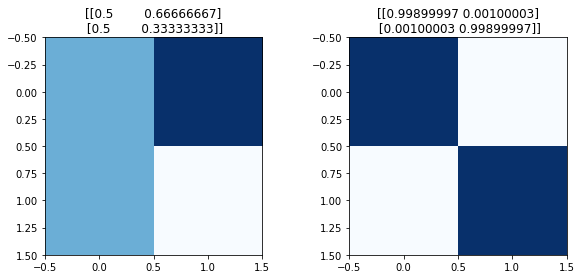

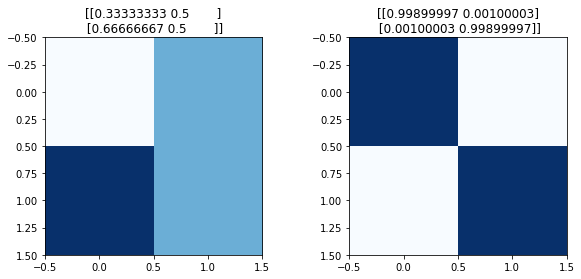

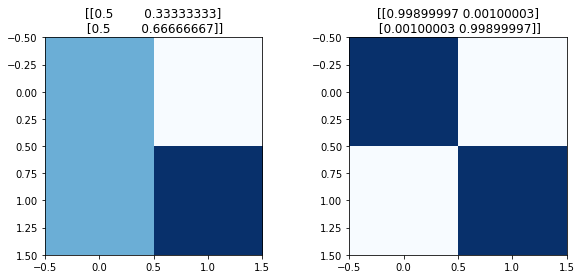

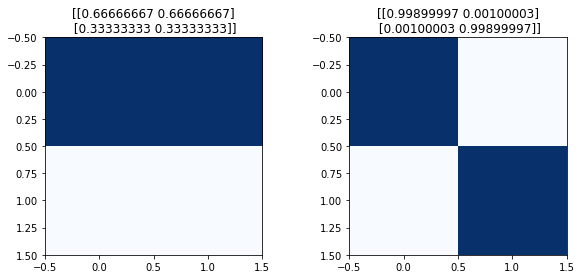

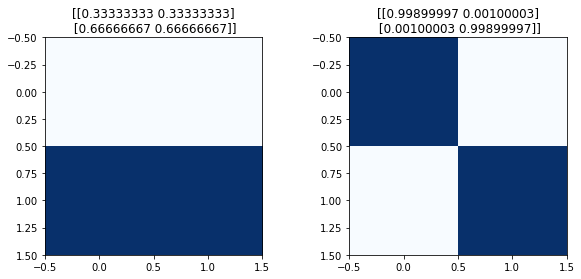

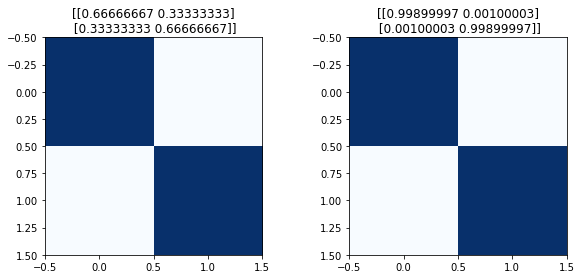

In [19]:
for e in pi_z_inits_ds:
    fig = plt.figure(figsize = [10,4])
    gs = GridSpec(1,2)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    ax1.imshow(e, 'Blues')
    ax2.imshow(pi_z_sol[4], 'Blues')
    ax1.set_title(e)
    ax2.set_title(pi_z_sol[4])

In [ ]:
# same support distributions

/home/gongui/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


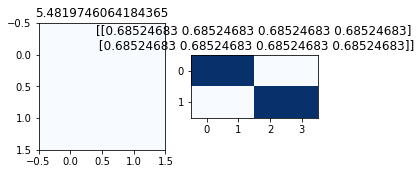

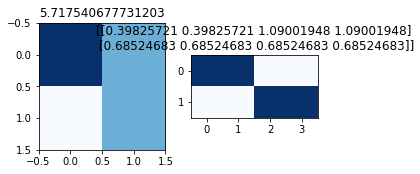

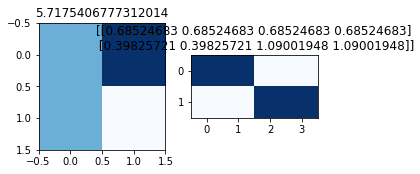

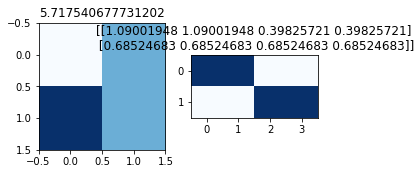

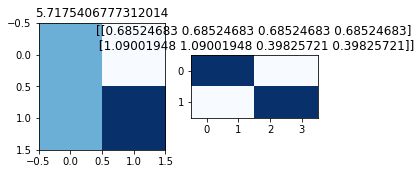

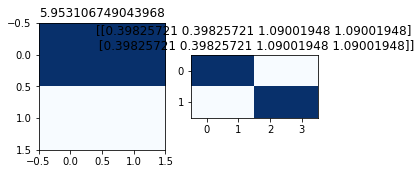

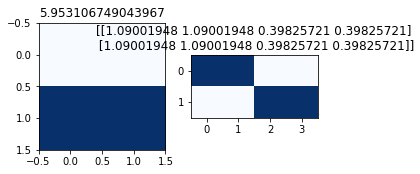

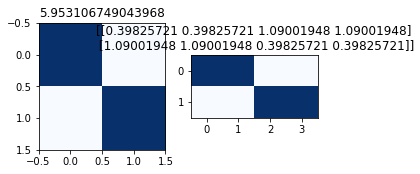

In [76]:
for e in pi_z_inits_ds:
    fig = plt.figure(figsize = [5,3])
    gs = GridSpec(1,2)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    ax1.imshow(e, 'Blues')
    ax2.imshow(pi_s, 'Blues')
    ax1.set_title(KL_div(e,pi_s))
    ax2.set_title(get_d_sz(e,pi_s))

# testing IB with dit package 

In [ ]:
import dit